# 分類モデル(LightGBM)

In [29]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import preprocessing
import japanize_matplotlib
# LightGBM
import lightgbm as lgb
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

## CSVファイルの読み込み

In [30]:
#データの読み込み
data_folder = input("データファイルのあるフォルダまでのパス")
data_folder = data_folder.rstrip()
data_folder = data_folder.replace("\\", "/") + "/"
    
file = data_folder + "input20001_30000_input+error.csv"

df = pd.read_csv(file,encoding="shift-jis")

In [31]:
#目的変数の設定
pur = "安全率エラー判定"

In [32]:
#　安全率のエラー判定
df.loc[df["遮水効果"].isna(),pur] = 1 #計算不可
df.loc[df["遮水効果"] >= 0, pur] = 0

In [33]:
pd.set_option('display.max_columns',50)
df

,堤体延長,堤体幅,左右壁体高さ,中詰土天端高さ,堤外区間地表面,堤内区間地表面,引張材間隔,在来地盤重量,在来地盤区分,在来地盤N値,在来地盤摩擦角,在来地盤粘着力,在来地盤変形係数,中詰め重量,中詰め区分,中詰めN値,中詰め摩擦角,中詰め粘着力,矢板型,矢板材料,引張材直径,引張材材料番号,腹起し材質,堤外側水位_常時,堤内側水位_常時,せん断変形破壊,滑動、支持力,根入れ部の安定,遮水効果,矢板の耐力照査,タイロッドの耐力照査,腹起しの耐力照査,矢板の全長,引張材位置,腹起し番号,根入れ深さ,せん断変形破壊_label,滑動、支持力_label,根入れ部の安定_label,遮水効果_label,矢板の耐力照査_label,タイロッドの耐力照査_label,腹起しの耐力照査_label,安全率エラー判定
0,20,5.7,4.0,3.9,0.0,0.0,1.6,12,1,7,24,165,179400,12,1,20,42,190,0,1,35,1,1,0.1,0.0,0.001200,0.016980,0.001000,0.030435,0.000000,0.000000,0.000000,6.9,0.5,5,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,8.2,6.8,6.7,3.1,0.0,1.6,20,0,28,7,242,59700,13,0,43,28,192,1,1,67,0,1,4.3,0.0,0.027998,0.074074,0.049689,0.693069,0.055319,0.023256,0.010811,12.0,5.7,4,5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,13.3,9.7,9.6,0.0,0.8,1.6,18,1,27,7,136,139100,17,0,35,22,9,2,1,28,1,0,8.4,0.1,0.237154,0.195440,0.236220,1.250000,0.353191,1.818182,0.614286,13.3,7.1,0,3.6,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0
3,13,10.6,8.5,8.4,0.0,1.0,1.6,12,0,11,21,272,118900,15,1,42,34,69,0,0,90,1,1,3.0,0.2,0.001200,0.030083,0.020192,0.360825,0.005556,0.000000,0.000000,12.4,4.9,2,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,11.8,5.9,5.8,0.0,0.9,0.8,16,0,21,35,10,59000,15,0,2,27,70,0,1,40,1,1,5.5,0.4,0.070217,0.268456,0.235756,0.498575,0.046809,0.078431,0.016216,15.7,2.7,1,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,11.7,6.2,6.1,0.0,0.3,1.6,17,1,44,1,176,76500,15,1,49,33,247,1,1,88,1,1,1.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,1.7,8,4.1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0
9996,13,10.0,5.4,5.3,1.8,0.0,1.6,14,0,0,45,156,192100,17,1,26,16,66,2,1,40,0,0,4.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1,3.0,4,2.7,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0
9997,23,9.2,5.0,4.9,1.7,0.0,1.6,19,1,27,6,0,166900,16,1,23,33,10,1,0,64,1,0,2.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,2.6,0,2.6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0
9998,13,11.9,9.3,9.2,1.6,0.0,0.8,14,0,2,43,260,95300,16,1,45,31,11,2,1,53,1,1,2.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,2.8,1,2.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0


## ラベルエンコーディング

In [34]:
pd.set_option('display.max_rows', 30)
df.dtypes

堤体延長                  int64
堤体幅                 float64
左右壁体高さ              float64
中詰土天端高さ             float64
堤外区間地表面             float64
                     ...   
遮水効果_label          float64
矢板の耐力照査_label       float64
タイロッドの耐力照査_label    float64
腹起しの耐力照査_label      float64
安全率エラー判定            float64
Length: 44, dtype: object

In [35]:
def label_en(la,df):
    label = df[la]
    le_embarked = LabelEncoder()
    le_embarked.fit(label)
    df[la] =  le_embarked.transform(label)
    df[la] = df[la].astype("category")
    return

#タイプ3:0，タイプ4:1，タイプ5:2
label_en('在来地盤区分',df)
label_en('中詰め区分',df)
label_en('矢板材料',df)
label_en('矢板型',df)
label_en('腹起し番号',df)
label_en('引張材材料番号',df)
label_en('腹起し材質',df)

df[pur] = df[pur].astype("int")


# label_en('せん断変形破壊_label',df)
# label_en('滑動、支持力_label',df)
# label_en('根入れ部の安定_label',df)
# label_en('遮水効果_label',df)
# label_en('矢板の耐力照査_label',df)
# label_en('タイロッドの耐力照査_label',df)
# label_en('腹起しの耐力照査_label',df)

In [36]:
#xgboostのときはダミーへんすうにしないといけない．

# df = pd.get_dummies(df)

In [37]:
df

,堤体延長,堤体幅,左右壁体高さ,中詰土天端高さ,堤外区間地表面,堤内区間地表面,引張材間隔,在来地盤重量,在来地盤区分,在来地盤N値,在来地盤摩擦角,在来地盤粘着力,在来地盤変形係数,中詰め重量,中詰め区分,中詰めN値,中詰め摩擦角,中詰め粘着力,矢板型,矢板材料,引張材直径,引張材材料番号,腹起し材質,堤外側水位_常時,堤内側水位_常時,せん断変形破壊,滑動、支持力,根入れ部の安定,遮水効果,矢板の耐力照査,タイロッドの耐力照査,腹起しの耐力照査,矢板の全長,引張材位置,腹起し番号,根入れ深さ,せん断変形破壊_label,滑動、支持力_label,根入れ部の安定_label,遮水効果_label,矢板の耐力照査_label,タイロッドの耐力照査_label,腹起しの耐力照査_label,安全率エラー判定
0,20,5.7,4.0,3.9,0.0,0.0,1.6,12,1,7,24,165,179400,12,1,20,42,190,0,1,35,1,1,0.1,0.0,0.001200,0.016980,0.001000,0.030435,0.000000,0.000000,0.000000,6.9,0.5,5,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,29,8.2,6.8,6.7,3.1,0.0,1.6,20,0,28,7,242,59700,13,0,43,28,192,1,1,67,0,1,4.3,0.0,0.027998,0.074074,0.049689,0.693069,0.055319,0.023256,0.010811,12.0,5.7,4,5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,23,13.3,9.7,9.6,0.0,0.8,1.6,18,1,27,7,136,139100,17,0,35,22,9,2,1,28,1,0,8.4,0.1,0.237154,0.195440,0.236220,1.250000,0.353191,1.818182,0.614286,13.3,7.1,0,3.6,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0
3,13,10.6,8.5,8.4,0.0,1.0,1.6,12,0,11,21,272,118900,15,1,42,34,69,0,0,90,1,1,3.0,0.2,0.001200,0.030083,0.020192,0.360825,0.005556,0.000000,0.000000,12.4,4.9,2,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,17,11.8,5.9,5.8,0.0,0.9,0.8,16,0,21,35,10,59000,15,0,2,27,70,0,1,40,1,1,5.5,0.4,0.070217,0.268456,0.235756,0.498575,0.046809,0.078431,0.016216,15.7,2.7,1,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,11.7,6.2,6.1,0.0,0.3,1.6,17,1,44,1,176,76500,15,1,49,33,247,1,1,88,1,1,1.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3,1.7,8,4.1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1
9996,13,10.0,5.4,5.3,1.8,0.0,1.6,14,0,0,45,156,192100,17,1,26,16,66,2,1,40,0,0,4.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1,3.0,4,2.7,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1
9997,23,9.2,5.0,4.9,1.7,0.0,1.6,19,1,27,6,0,166900,16,1,23,33,10,1,0,64,1,0,2.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,2.6,0,2.6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1
9998,13,11.9,9.3,9.2,1.6,0.0,0.8,14,0,2,43,260,95300,16,1,45,31,11,2,1,53,1,1,2.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,2.8,1,2.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1


In [38]:
# 安全率はエラー判定分類には用いないので，カットする

safety_label =  ["せん断変形破壊","滑動、支持力","根入れ部の安定","遮水効果","矢板の耐力照査","タイロッドの耐力照査","腹起しの耐力照査","矢板の全長","せん断変形破壊_label","滑動、支持力_label","根入れ部の安定_label","遮水効果_label","矢板の耐力照査_label","タイロッドの耐力照査_label","腹起しの耐力照査_label"]
df = df.drop([i for i in safety_label],axis=1)

In [39]:
df

,堤体延長,堤体幅,左右壁体高さ,中詰土天端高さ,堤外区間地表面,堤内区間地表面,引張材間隔,在来地盤重量,在来地盤区分,在来地盤N値,在来地盤摩擦角,在来地盤粘着力,在来地盤変形係数,中詰め重量,中詰め区分,中詰めN値,中詰め摩擦角,中詰め粘着力,矢板型,矢板材料,引張材直径,引張材材料番号,腹起し材質,堤外側水位_常時,堤内側水位_常時,引張材位置,腹起し番号,根入れ深さ,安全率エラー判定
0,20,5.7,4.0,3.9,0.0,0.0,1.6,12,1,7,24,165,179400,12,1,20,42,190,0,1,35,1,1,0.1,0.0,0.5,5,2.9,0
1,29,8.2,6.8,6.7,3.1,0.0,1.6,20,0,28,7,242,59700,13,0,43,28,192,1,1,67,0,1,4.3,0.0,5.7,4,5.2,0
2,23,13.3,9.7,9.6,0.0,0.8,1.6,18,1,27,7,136,139100,17,0,35,22,9,2,1,28,1,0,8.4,0.1,7.1,0,3.6,0
3,13,10.6,8.5,8.4,0.0,1.0,1.6,12,0,11,21,272,118900,15,1,42,34,69,0,0,90,1,1,3.0,0.2,4.9,2,3.9,0
4,17,11.8,5.9,5.8,0.0,0.9,0.8,16,0,21,35,10,59000,15,0,2,27,70,0,1,40,1,1,5.5,0.4,2.7,1,9.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,11.7,6.2,6.1,0.0,0.3,1.6,17,1,44,1,176,76500,15,1,49,33,247,1,1,88,1,1,1.6,0.2,1.7,8,4.1,1
9996,13,10.0,5.4,5.3,1.8,0.0,1.6,14,0,0,45,156,192100,17,1,26,16,66,2,1,40,0,0,4.4,0.0,3.0,4,2.7,1
9997,23,9.2,5.0,4.9,1.7,0.0,1.6,19,1,27,6,0,166900,16,1,23,33,10,1,0,64,1,0,2.8,0.0,2.6,0,2.6,1
9998,13,11.9,9.3,9.2,1.6,0.0,0.8,14,0,2,43,260,95300,16,1,45,31,11,2,1,53,1,1,2.3,0.0,2.8,1,2.5,1


In [40]:
df.to_csv(f"{data_folder}" + "input20001_30000_input+error_dummy.csv",encoding="shift-jis",index=None)

## 相関を調べる

In [41]:
# 目的変数の設定
pur = "安全率エラー判定"

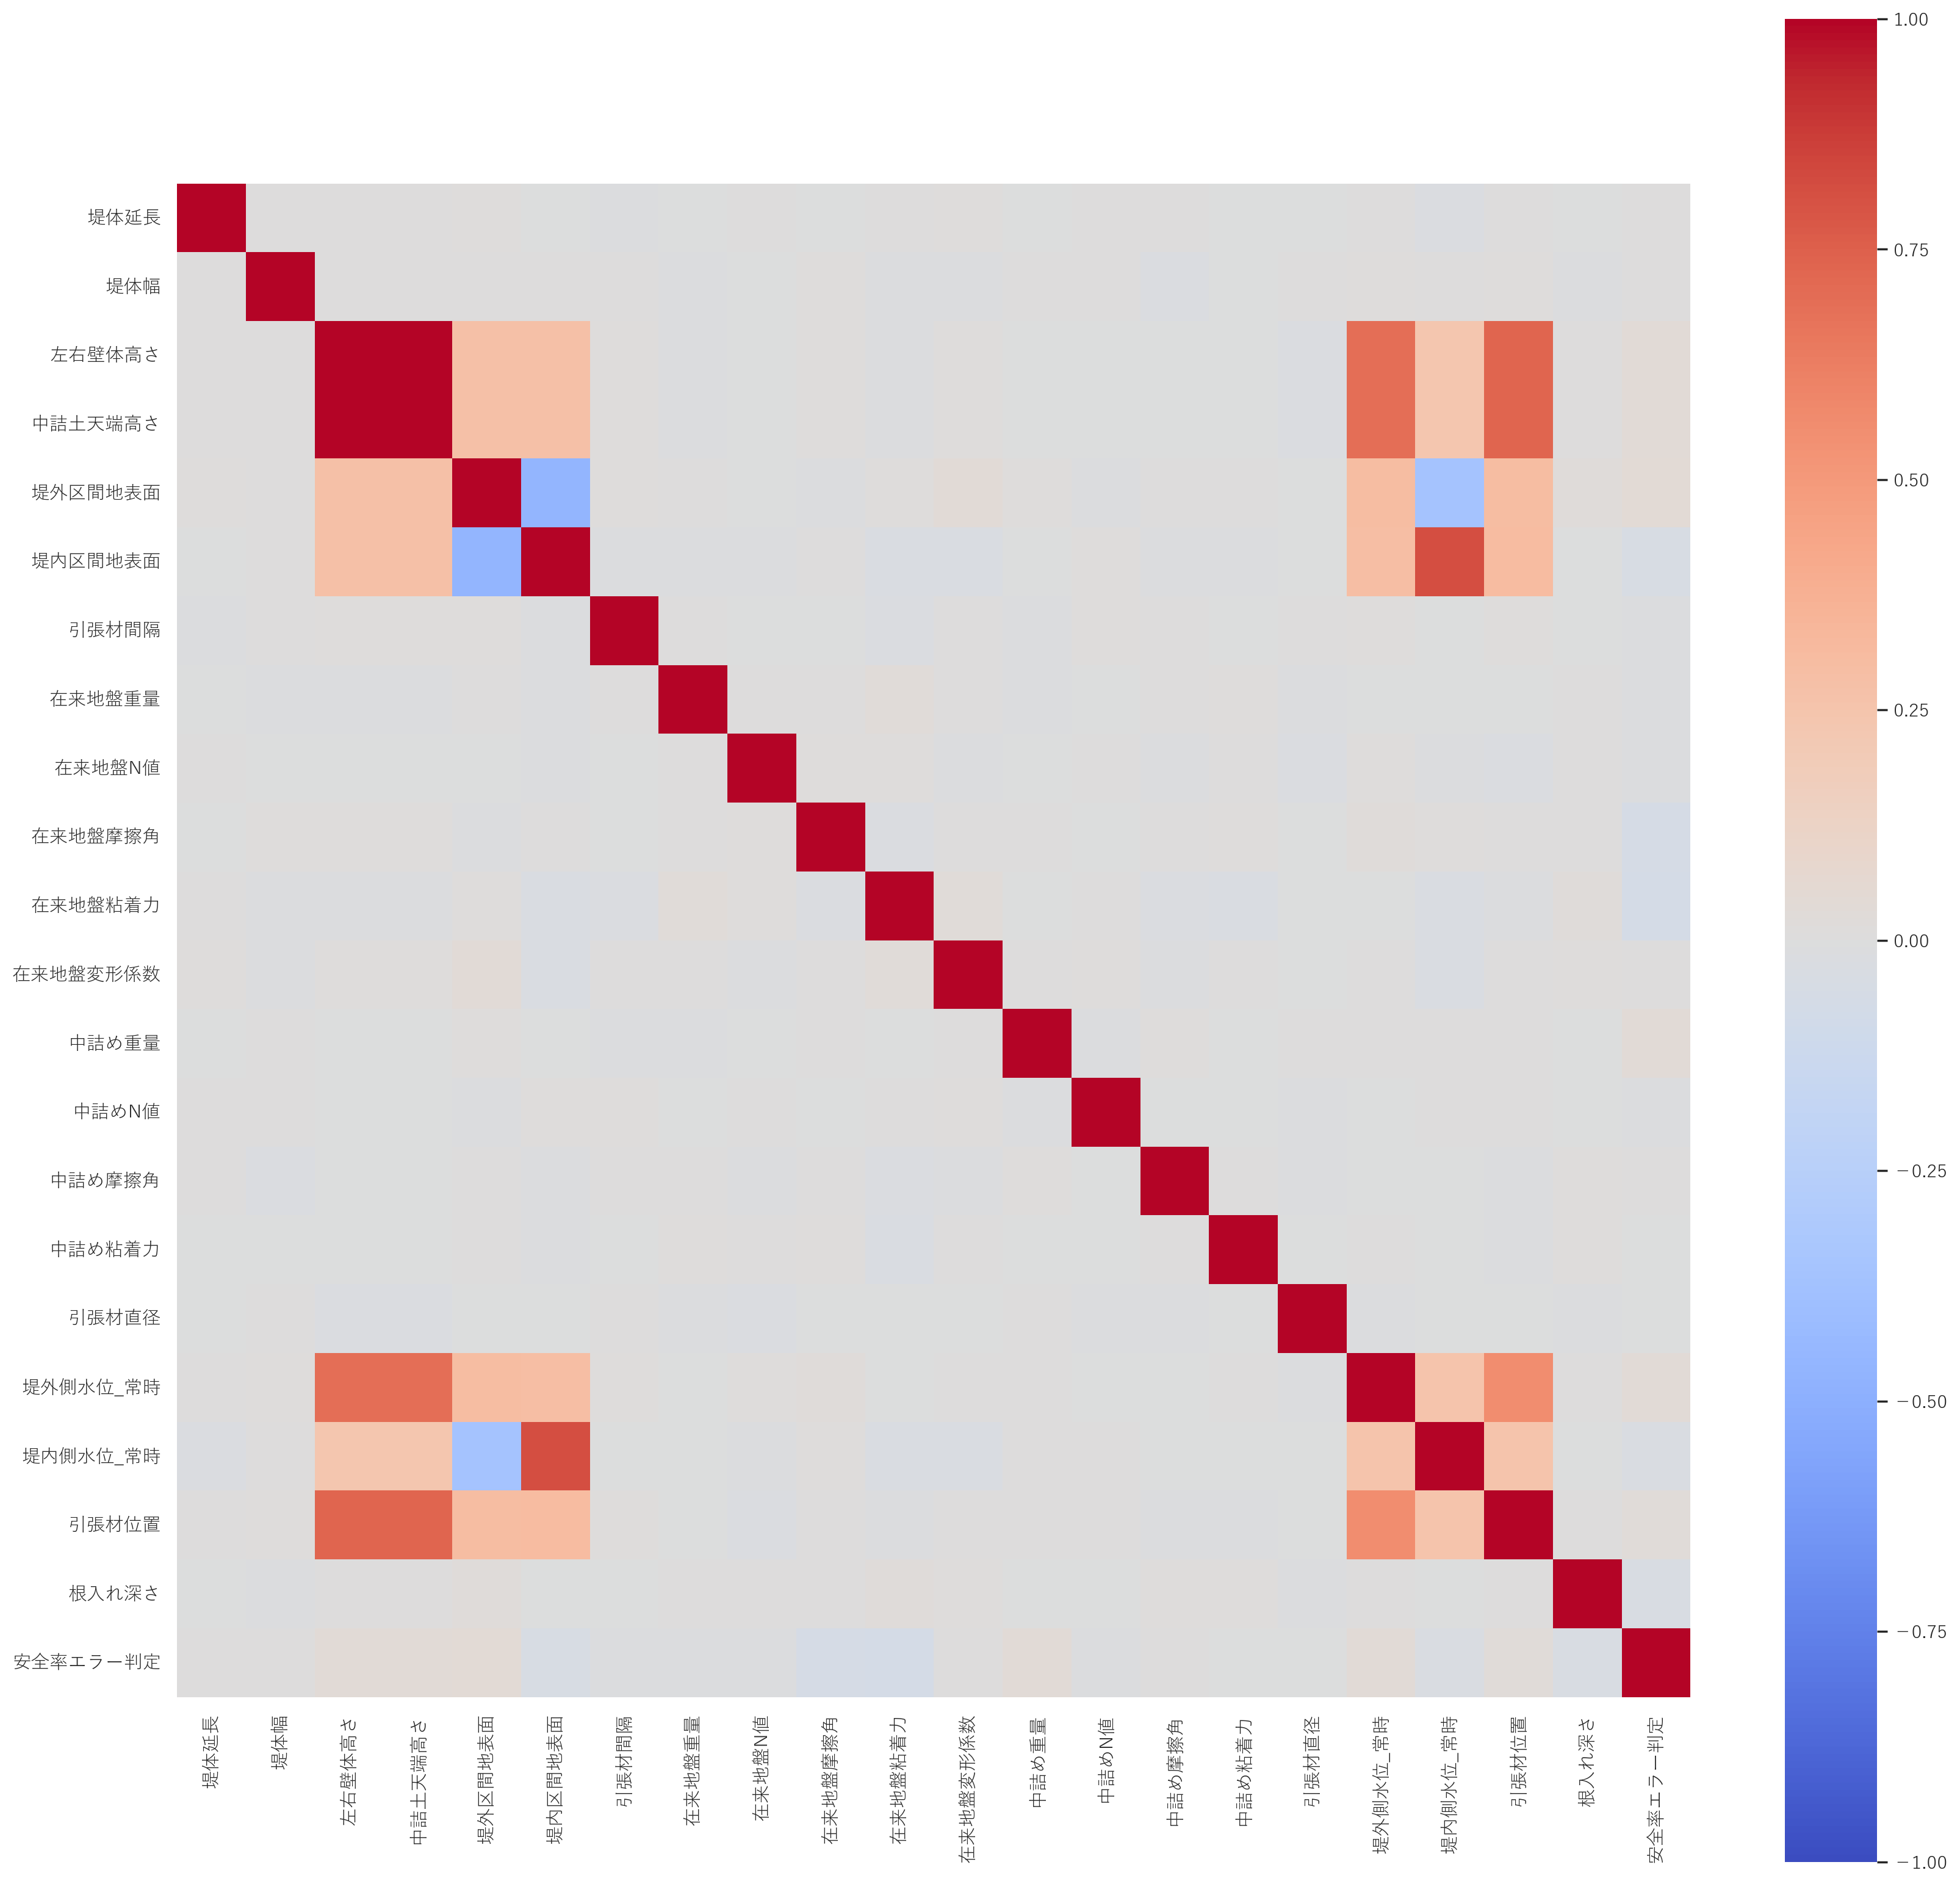

In [42]:
# sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font='Yu Gothic')
plt.figure(figsize=(20,20),dpi=200)
p=sns.heatmap(df.corr(),square=True, vmax=1, vmin=-1, center=0,cmap='coolwarm')

<AxesSubplot:>

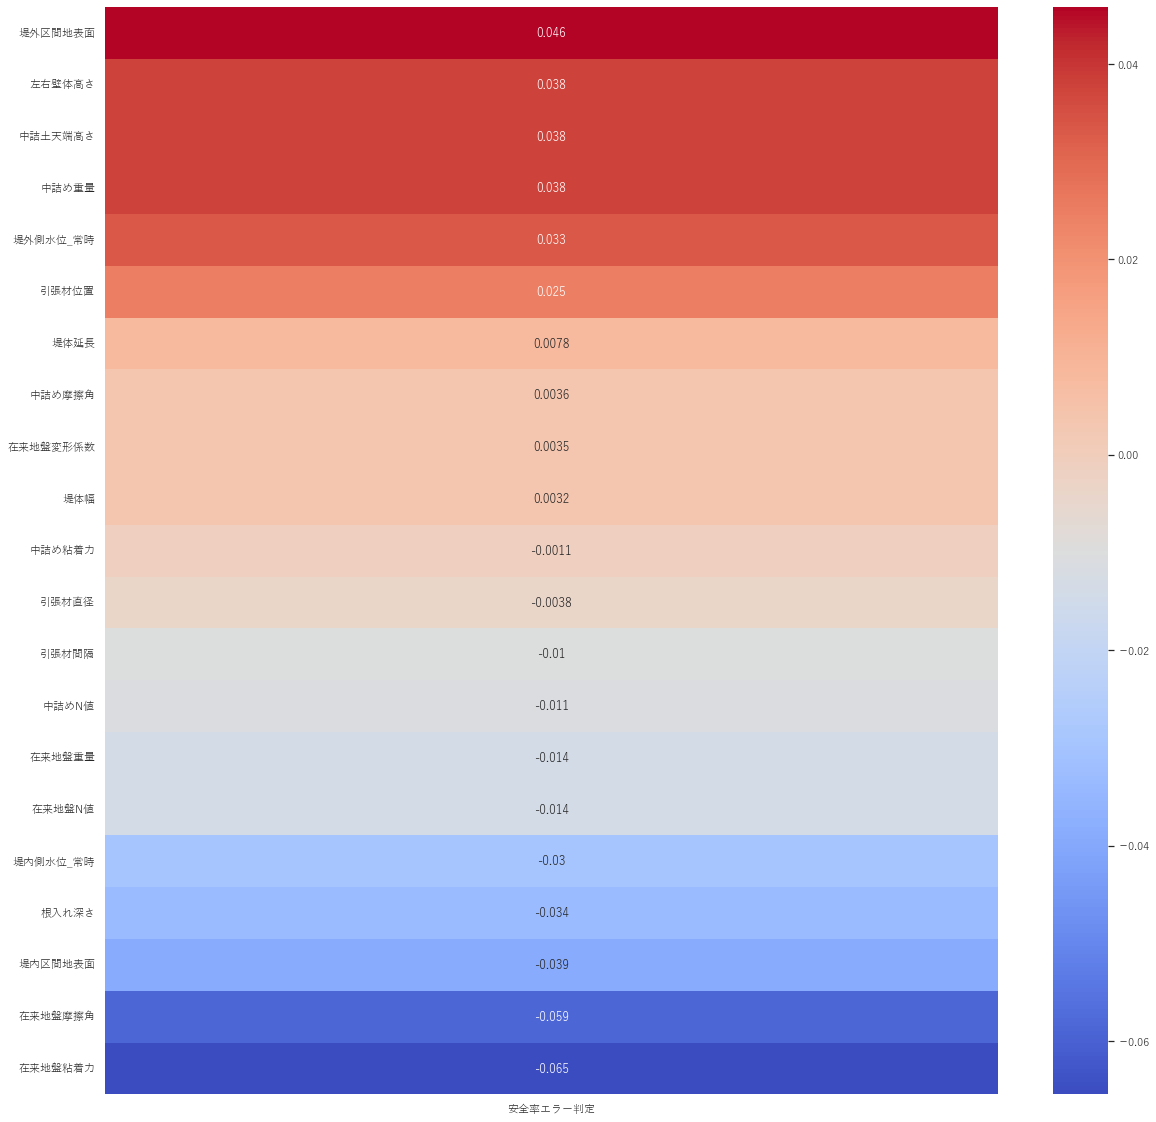

In [43]:
sns.set(font='Yu Gothic',rc = {'figure.figsize':(20,20)})
sns.heatmap(df.corr()[[pur]].sort_values(by=pur, ascending=False)[1:],cmap='coolwarm', annot=True)

In [44]:
df

,堤体延長,堤体幅,左右壁体高さ,中詰土天端高さ,堤外区間地表面,堤内区間地表面,引張材間隔,在来地盤重量,在来地盤区分,在来地盤N値,在来地盤摩擦角,在来地盤粘着力,在来地盤変形係数,中詰め重量,中詰め区分,中詰めN値,中詰め摩擦角,中詰め粘着力,矢板型,矢板材料,引張材直径,引張材材料番号,腹起し材質,堤外側水位_常時,堤内側水位_常時,引張材位置,腹起し番号,根入れ深さ,安全率エラー判定
0,20,5.7,4.0,3.9,0.0,0.0,1.6,12,1,7,24,165,179400,12,1,20,42,190,0,1,35,1,1,0.1,0.0,0.5,5,2.9,0
1,29,8.2,6.8,6.7,3.1,0.0,1.6,20,0,28,7,242,59700,13,0,43,28,192,1,1,67,0,1,4.3,0.0,5.7,4,5.2,0
2,23,13.3,9.7,9.6,0.0,0.8,1.6,18,1,27,7,136,139100,17,0,35,22,9,2,1,28,1,0,8.4,0.1,7.1,0,3.6,0
3,13,10.6,8.5,8.4,0.0,1.0,1.6,12,0,11,21,272,118900,15,1,42,34,69,0,0,90,1,1,3.0,0.2,4.9,2,3.9,0
4,17,11.8,5.9,5.8,0.0,0.9,0.8,16,0,21,35,10,59000,15,0,2,27,70,0,1,40,1,1,5.5,0.4,2.7,1,9.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25,11.7,6.2,6.1,0.0,0.3,1.6,17,1,44,1,176,76500,15,1,49,33,247,1,1,88,1,1,1.6,0.2,1.7,8,4.1,1
9996,13,10.0,5.4,5.3,1.8,0.0,1.6,14,0,0,45,156,192100,17,1,26,16,66,2,1,40,0,0,4.4,0.0,3.0,4,2.7,1
9997,23,9.2,5.0,4.9,1.7,0.0,1.6,19,1,27,6,0,166900,16,1,23,33,10,1,0,64,1,0,2.8,0.0,2.6,0,2.6,1
9998,13,11.9,9.3,9.2,1.6,0.0,0.8,14,0,2,43,260,95300,16,1,45,31,11,2,1,53,1,1,2.3,0.0,2.8,1,2.5,1


C:\Users\kmizu\AppData\Local\Temp/ipykernel_14308/1915455057.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


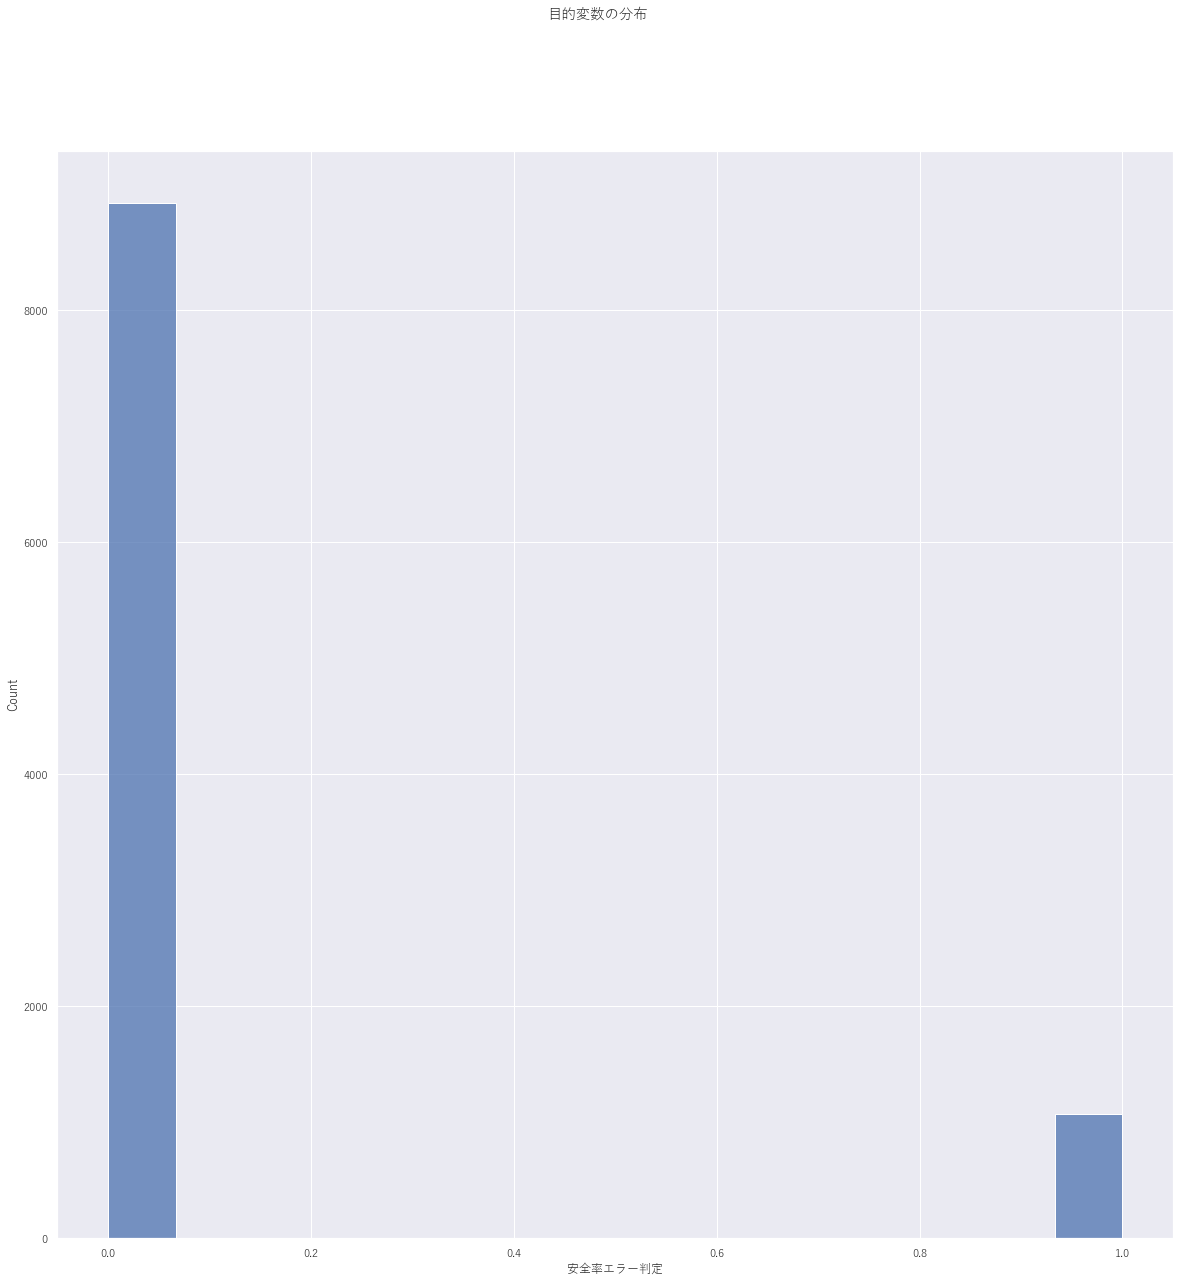

<Figure size 4000x4000 with 0 Axes>

In [45]:
#目的変数の分布
def plot_histgram(x, title=None, x_label=None):
    fig,ax = plt.subplots()
    sns.set(font='Yu Gothic',rc = {'figure.figsize':(12,6)})

    plt.figure(figsize=(8,8),dpi=500)
    sns.histplot(x, kde = False, ax=ax)
    fig.suptitle(title)
    ax.set_xlabel(x_label)

    fig.show()

plot_histgram(df[pur], title="目的変数の分布", x_label=pur)

In [46]:
df[pur].describe()

count    10000.000000
mean         0.107200
std          0.309383
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: 安全率エラー判定, dtype: float64

c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anacond

<Figure size 800x800 with 0 Axes>

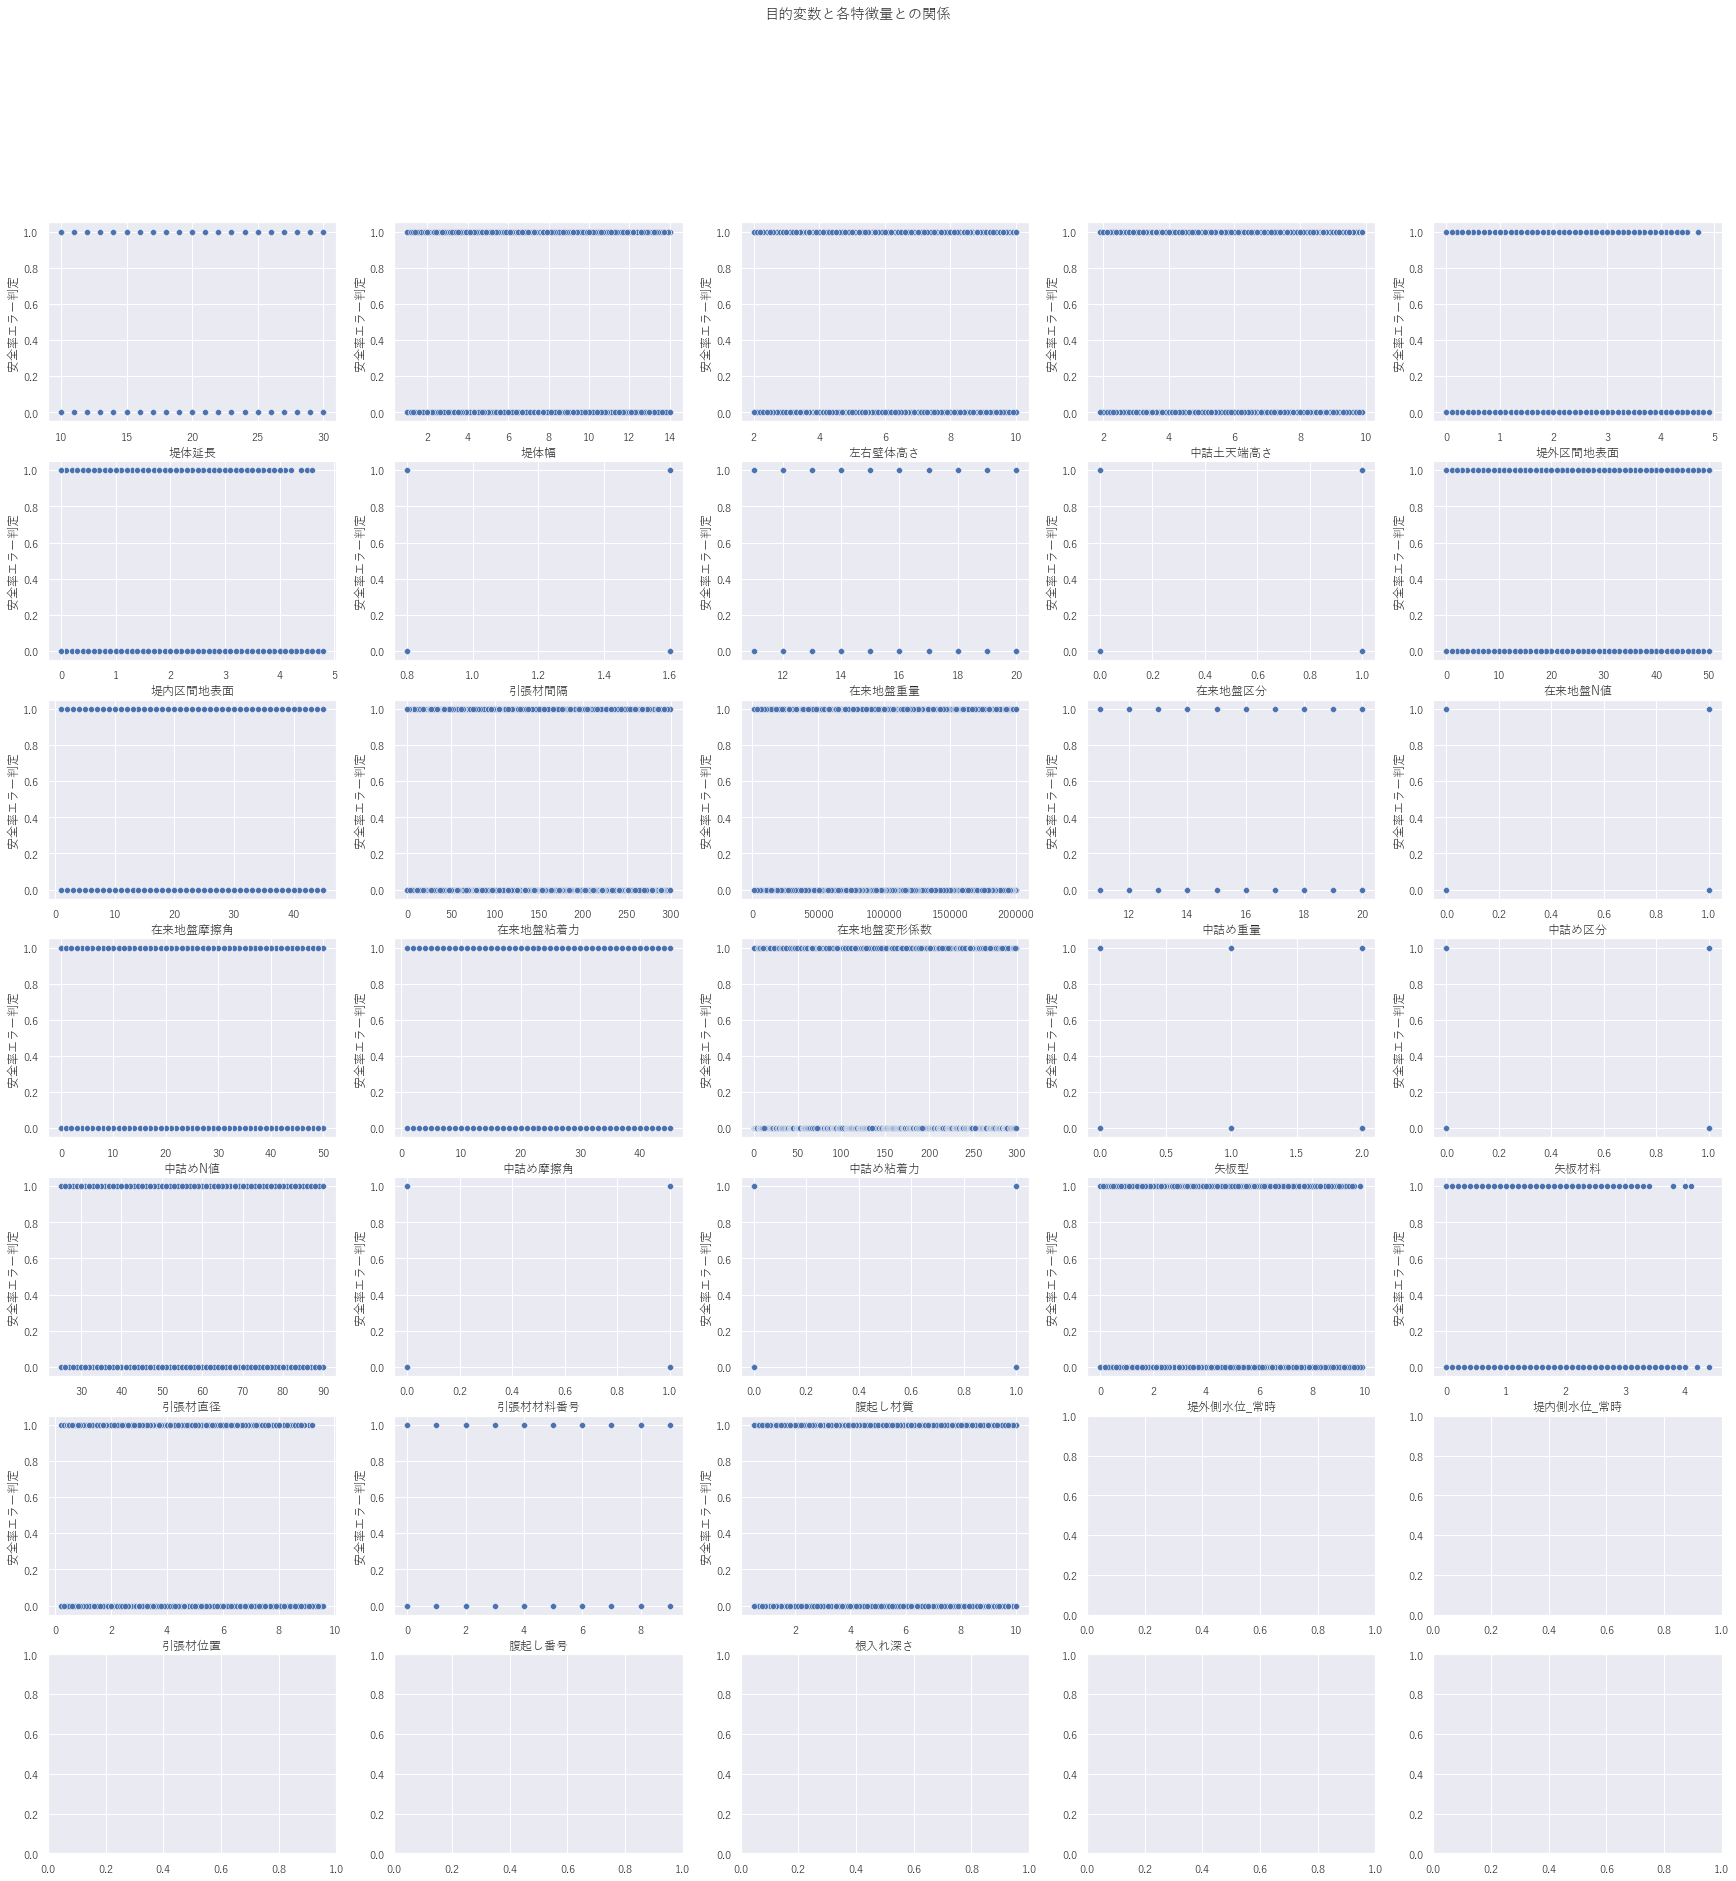

In [47]:
#目的変数と各特徴量の関係
def plt_scatters(X, y, title = None,nrows=2,ncols=2):
    # sns.set(rc = {'figure.figsize':(15,8)})
    sns.set(font='Yu Gothic',rc = {'figure.figsize':(30,30)})

    cols = X.columns
    plt.figure(figsize=(4,4),dpi=200)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for ax,c in zip(axes.ravel(),cols):
        sns.scatterplot(X[c], y , ci=None, ax=ax)
        ax.set(ylabel = y.name)
    

    fig.suptitle(title)
    fig.show()

xx = df.drop([pur], axis = 1)
plt_scatters(
    df[xx.columns],
    df[pur],
    title = "目的変数と各特徴量との関係",
    nrows = 7,
    ncols = 5
)

c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\kmizu\AppData\Local\Temp/ipykernel_14308/327855415.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 800x800 with 0 Axes>

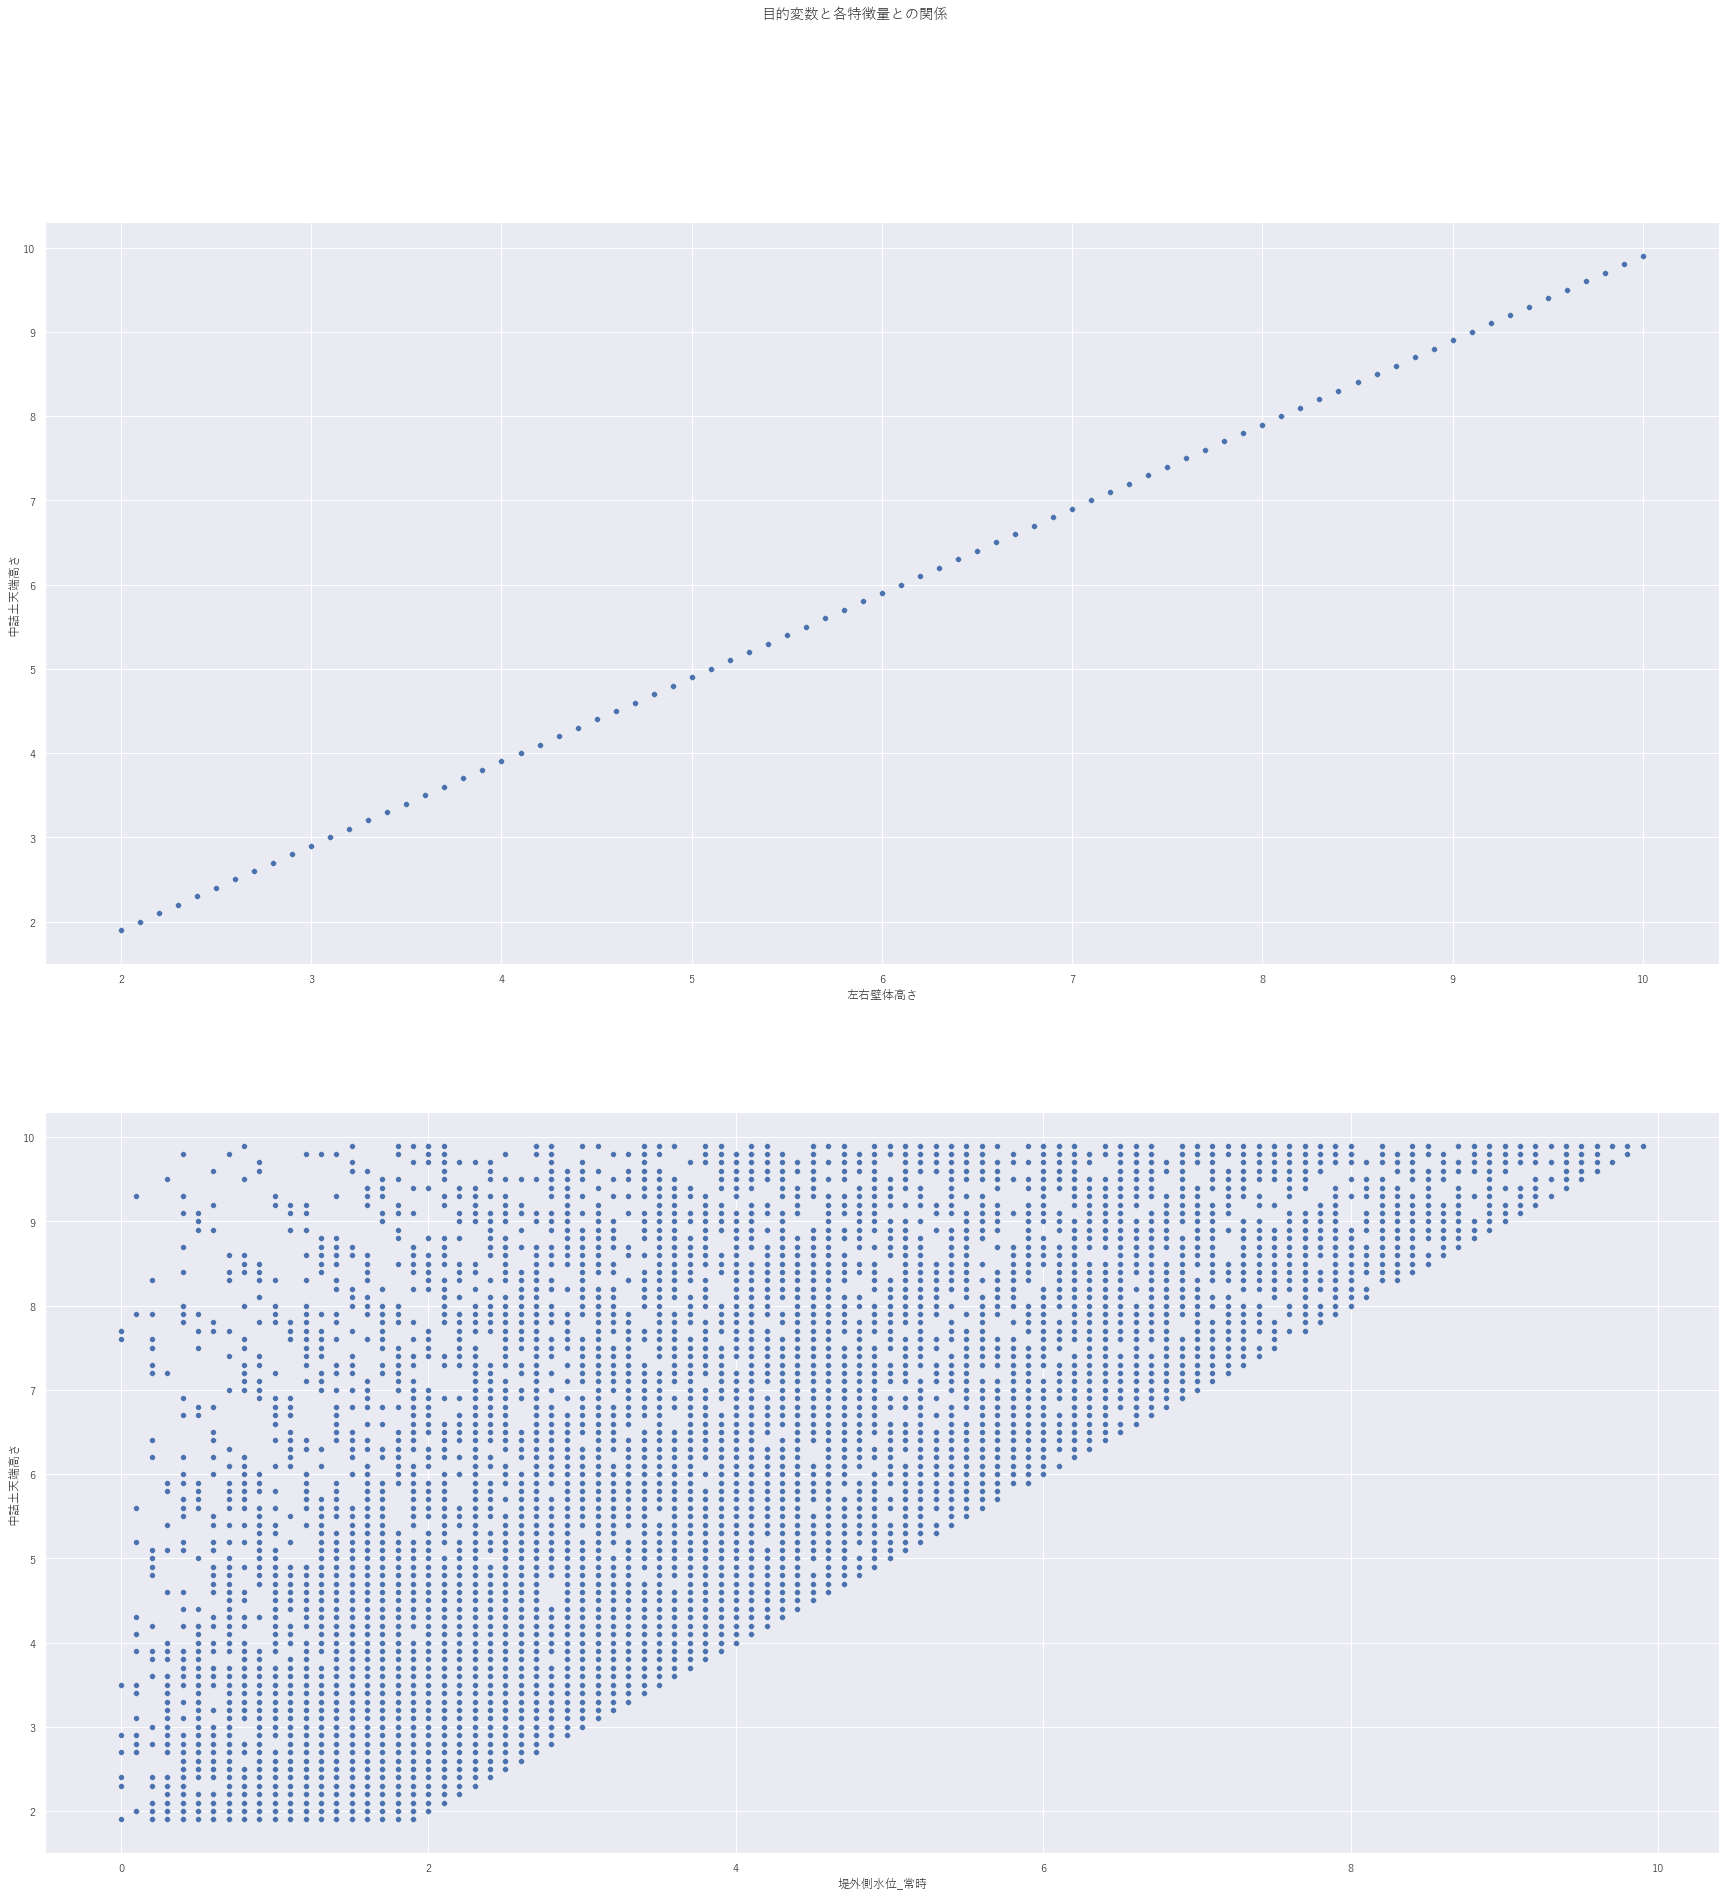

In [48]:
plt_scatters(
    df[['左右壁体高さ','堤外側水位_常時']],
    df['中詰土天端高さ'],
    title = "目的変数と各特徴量との関係",
    nrows = 2,
    ncols = 1
)

## モデルの作成

### データの分割

In [49]:
# データの分割
# 全体の20%をテストデータに設定

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 3,stratify=df[pur])

In [50]:
# # Stratified K Foldでデータを分割
# from imblearn.under_sampling import RandomUnderSampler
# # 目的変数と説明変数に分ける
# x_train = train.drop([pur], axis = 1) # 予測対象以外を説明変数に設定
# y_train = train.loc[:,pur]

In [51]:
# y_train

### アンダーサンプリングとクロスバリデーション

In [53]:
from imblearn.under_sampling import RandomUnderSampler
# 目的変数と説明変数に分ける
X = train.drop([pur], axis = 1) # 予測対象以外を説明変数に設定
y = train.loc[:,pur]

# sampler = RandomUnderSampler(sampling_strategy={0: y.value_counts()[1]*2, 1: y.value_counts()[1]}, random_state=42)
# X, y = sampler.fit_resample(X, y)

# 3：1でアンダーサンプリング
positive_count_train = y.value_counts()[1]
strategy = {0.0:positive_count_train*3, 1.0:positive_count_train}
rus=RandomUnderSampler(random_state=9, sampling_strategy = strategy)
X, y = rus.fit_resample(X, y)
train = pd.concat([y,X],axis=1)

# データの分割
# ライブラリのインポート
## Stratified K Fold(層状k分割)でデータを分割
from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) # データを5分割する
kf = fold.split(X, y)
kf_cv = list(kf)

In [ ]:
for i, (idx_train, idx_val) in enumerate(kf_cv):
    print(f'fold {i}')
    print(idx_train)
    print(idx_val)
    print('=='*30)
    print(len(idx_train), len(idx_val)) #5分割しているのでデータ数が1:4になるか確認する
    print('=='*30)

## LightGBM

In [54]:
# from xgboost.callback import early_stop
from sklearn.metrics import accuracy_score # 正解率を出すためのライブラリ
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score

# XGBoost

In [ ]:
# # from xgboost.callback import early_stop
# import xgboost as xgb
# from sklearn import metrics # 正解率を出すためのライブラリ
# from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score

### ハイパーパラメータチューニング

In [ ]:
# params_base = {
#     "boosting_type": "gbdt",
#     'objective': 'binary', 
#     'n_estimators': 10000,
#     "subsample":0.7,
#     'subsample_freq': 1,
#     "seed": 123,
# }

In [ ]:
# def objective(trial, df_X, df_y):

#     params_tuning = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
#         "num_leaves": trial.suggest_int("num_leaves", 8, 256),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 200),
#         "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2,log=True),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e2, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e2, log=True)
#     }

#     params_tuning.update(params_base)


#     model = lgb.LGBMClassifier(**params_tuning)

#     # 交差検証
#     scores = cross_val_score(model, df_X, df_y,cv=5,scoring="roc_auc")
#     score_mean = np.mean(scores)
#     # rmse = np.sqrt(-scores)
#     # score_mean = np.mean(rmse)

#     return scores


In [ ]:
# X=X.reset_index()
# y=y.reset_index()

In [ ]:
# y=y["安全率エラー判定"]

In [56]:
# 探索しないハイパーパラメータ
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.02,
    'n_estimators': 100000,
    "bagging_freq": 1,
    "seed": 123,
}

def objective(trial,df_X,df_y):
    # 探索するハイパーパラメータ
    params_tuning = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    model = lgb.LGBMClassifier(**params_tuning)
    # model = clf.fit(x_tr,y_tr,
    #               eval_set=[(x_va,y_va)],
    #               early_stopping_rounds=100,
    #               verbose=0,
    #              )  
    scores = cross_val_score(model, df_X, df_y,cv=5,scoring="accuracy")
    score_mean = np.mean(scores)
    
    # # モデル学習・評価
    # list_metrics = []
    # # cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=3).split(X, y))
    
    # for i, (idx_train, idx_val) in enumerate(kf_cv):        
    #     # idx_tr, idx_va = kf_cv[nfold][0], kf_cv[nfold][1]
    #     # X_train, y_train = X.iloc[idx_train], y.iloc[idx_train] # 学習用の説明変数と目的変数の呼び出し
    #     # X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]
    #     x_tr, y_tr = X.loc[idx_train], y.loc[idx_train]
    #     x_va, y_va = X.loc[idx_val], y.loc[idx_val]
    #     clf = lgb.LGBMClassifier(**params_tuning)
    #     model = clf.fit(x_tr,y_tr,
    #               eval_set=[(x_va,y_va)],
    #               early_stopping_rounds=100,
    #               verbose=0,
    #              )
    #     y_va_pred = model.predict_proba(x_va)[:,1]
    #     metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5, 1, 0))
    #     list_metrics.append(metric_va)
    
    # # 評価値の計算
    # metrics = np.mean(list_metrics)
    
    return score_mean

In [58]:
# study = optuna.create_study(sampler=sampler, direction="maximize")
# study.optimize(objective, n_trials=30)

sampler = optuna.samplers.TPESampler(seed=123)
# optuna.create_study()でoptuna.studyインスタンスを作る。
study = optuna.create_study(sampler = sampler,direction = 'maximize')

#studyインスタンスのoptimize()に作った関数を渡して最適化する。
study.optimize(lambda trial: objective(trial,X,y),n_trials=200, timeout=300)

[I 2022-08-29 18:23:45,160] A new study created in memory with name: no-name-61a4e9d2-4016-451b-9693-faa44d86aeda


[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] lambda_l1 is set=0.492522233779106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.492522233779106
[LightGBM] [Warning] lambda_l2 is set=83.76388146302445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.76388146302445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2022-08-29 18:26:34,980] Trial 0 finished with value: 0.7438807338281539 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'lambda_l1': 0.492522233779106, 'lambda_l2': 83.76388146302445}. Best is trial 0 with value: 0.7438807338281539.


[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] lambda_l1 is set=0.567922374174008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.567922374174008
[LightGBM] [Warning] lambda_l2 is set=0.01732652966363563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01732652966363563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[I 2022-08-29 18:27:33,283] Trial 1 finished with value: 0.7491293959879647 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'lambda_l1': 0.567922374174008, 'lambda_l2': 0.01732652966363563}. Best is trial 1 with value: 0.7491293959879647.


[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] lambda_l1 is set=1.3406343673102123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3406343673102123
[LightGBM] [Warning] lambda_l2 is set=3.4482904089131434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4482904089131434
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[I 2022-08-29 18:28:45,736] Trial 2 finished with value: 0.7363039538959688 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'lambda_l1': 1.3406343673102123, 'lambda_l2': 3.4482904089131434}. Best is trial 1 with value: 0.7491293959879647.


In [ ]:
# import optuna
# def objective(trial,df_X,df_y):
    
#     params ={
#     'max_depth':trial.suggest_int("max_depth",3,10),
#     'min_child_weight':trial.suggest_int('min_child_weight',1,5),
#     'gamma':trial.suggest_uniform('gamma',0,5),
#     'subsample':trial.suggest_uniform('subsample',0.5,1),
#     'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.5,1),
#     'learning_rate':trial.suggest_uniform('learning_rate',0,1)}

#     model = xgb.XGBClassifier(n_estimators=100,
#                             verbosity=0,
#                             n_jobs=-1,
#                             random_state=0,
#                             **params)

#     #交差検証
#     scores = cross_val_score(model, df_X, df_y,cv=5,scoring="accuracy")
#     score_mean = np.mean(scores)

#     return score_mean

In [ ]:
# # optuna.create_study()でoptuna.studyインスタンスを作る。
# study = optuna.create_study(direction = 'maximize')

# #studyインスタンスのoptimize()に作った関数を渡して最適化する。
# study.optimize(lambda trial: objective(trial,X,y),n_trials=200, timeout=300)

In [ ]:
params_best = study.best_params
params_best.update(params_base)
display(params_best)

In [ ]:
#スコアを見る
print(study.best_params)    

In [ ]:
print(study.best_value)

In [ ]:
# # 今回は最低限のパラメーターだけ設定します。
# xgb_params = {
#     'objective': 'binary:logistic',  # 2値分類問題
#     'eval_metric': 'logloss',       # 学習用の指標
# }

In [ ]:
# xgb_params['max_depth'] = study.best_params['max_depth']
# xgb_params['min_child_weight'] = study.best_params['min_child_weight']
# xgb_params['gamma'] = study.best_params['gamma']
# xgb_params['subsample'] = study.best_params['subsample']
# xgb_params['colsample_bytree'] = study.best_params['colsample_bytree']
# xgb_params['learning_rate'] = study.best_params['learning_rate']

In [ ]:
# xgb_params = {
#     'objective': 'reg:squarederror',  # 回帰問題
#     'eval_metric': 'rmse',       # 学習用の指標
# }

In [ ]:
# xgb_params['max_depth'] = study.best_params['max_depth']
# xgb_params['min_child_weight'] = study.best_params['min_child_weight']
# xgb_params['gamma'] = study.best_params['gamma']
# xgb_params['subsample'] = study.best_params['subsample']
# xgb_params['colsample_bytree'] = study.best_params['colsample_bytree']
# xgb_params['learning_rate'] = study.best_params['learning_rate']
# # xgb_params['reg_alpha'] = study.best_params['reg_alpha']
# # xgb_params['reg_lambda'] = study.best_params['reg_lambda']

### 学習開始

In [ ]:
# import optuna
# from sklearn.metrics import average_precision_score
# import shap

# def fit_xgb(X, y, cv, params: dict=None):
    
#     models = []
#     acc = []
#     oof_plob = np.zeros(len(X))
#     oof_classfication = np.zeros(len(X))

#     if params is None:
#         params = {}

#     threshold_all = []
#     for i, (idx_train, idx_val) in enumerate(kf_cv):
#         X_train, y_train = X.iloc[idx_train], y.iloc[idx_train] # 学習用の説明変数と目的変数の呼び出し
#         X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]

#         clf = xgb.XGBClassifier(**params)
#         model = clf.fit(X_train, y_train,
#                         eval_set=[(X_val, y_val)],  
#                         early_stopping_rounds=20,
#                         verbose = 2)

#         pred_prob = model.predict_proba(X_val)[:,1] # どのクラスに分類されるのかの確率を算出
#         print(pred_prob)

#         explainer = shap.TreeExplainer(model = model,data=X_train,feature_perturbation="interventional")
#         shap_values = explainer(X_train)
#         shap.plots.bar(shap_values=shap_values,max_display=40)
#         shap.plots.beeswarm(shap_values,max_display=40)

#         # xgb_shap_values = xgb_explainer.shap_values(X_train)
#         # XgboostでのViolin Plotの可視化
#         # shap.summary_plot(xgb_shap_values, X_train, plot_size=[20,20])
#         # # XgboostでのPartial Dependence Plotの可視化
#         # shap.dependence_plot("rank(0)", xgb_shap_values, X_train)
#         # shap.summary_plot(xgb_shap_values, X, plot_type="bar",plot_size=[20,20])

        
#         def calc_metrics_derived_from_confusion_matrix(metrics_name, y_true, y_predict):
#             tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_predict).ravel()
#             #  PPV, precision
#             #  TP / TP + FP
#             if metrics_name in ["PPV", "precision"]:
#                 return tp / (tp + fp)

#             #  NPVD
#             #  TN / TN + FN
#             if metrics_name in ["NPV"]:
#                 return tn / (tn + fn)

#             # sensitivity, recall, TPR
#             #  TP / TP + FN
#             if metrics_name in ["sensitivity", "recall", "TPR"]:
#                 return tp / (tp + fn)

#             # specificity
#             #  TN / TN + FP
#             if metrics_name in ["specificity"]:
#                 return tn / (tn + fp)
       
#         def accuracy(y_val, pred_prob, threshold):
#             pred = [1 if prob >= threshold else 0 for prob in pred_prob]
#             score = metrics.f1_score(y_val, pred)
#             # score = calc_metrics_derived_from_confusion_matrix("specificity",y_val, pred)
#             return score
        
#         def objective(trial):
#             threshold = trial.suggest_float('threshold', 0.0, 1.0) # 0~1.0で探索
#             ret = accuracy(y_val, pred_prob, threshold)
#             return ret
        
#         # 閾値の最適化
#         study = optuna.create_study(direction="maximize")
#         study.optimize(objective, n_trials=200)

#         # 閾値の呼び出し
#         best_threshold = sorted(study.best_params.values())
#         pred = np.where(pred_prob > best_threshold,1,0)
#         # pred = np.where(pred_prob > 0.27,1,0)

#         print(best_threshold)
        
#         oof_plob[idx_val] = pred_prob
#         # pred = np.argmax(pred_prob, axis = 1) # 確率が一番大きなクラスに分類
#         print(pred)
        
#         oof_classfication[idx_val] = pred

#         # oof[idx_val] = pred_prob
#         models.append(model)
#         threshold_all.append(best_threshold[0])

#         # print(f'正解率：{metrics.accuracy_score(y_val, pred)}')
#         acc.append(metrics.accuracy_score(y_val, pred))
    
#     print(f'classification_report：{metrics.classification_report(y_val, pred)}')


#     # print(f'平均正解率：{np.mean(acc)}')
#     return oof_plob,oof_classfication, models, threshold_all

In [ ]:
# oof_plob,oof_classfication, models,threshold_all = fit_xgb(X, y, kf_cv, xgb_params)

In [ ]:
import shap
def fit_lgb(X, y, cv, params):
    models = []
    acc = []
    oof = np.zeros(len(X))
    prob_oof = np.zeros((len(y),len(y.unique()))) # 学習と推論で乖離がないか確認するために予測確率も記録する。
    for i, (idx_train, idx_val) in enumerate(kf_cv):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train] # 学習用の説明変数と目的変数の呼び出し
        print(X_train.shape)
        X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]
        clf = lgb.LGBMClassifier(**params)
        model = clf.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],  
                        early_stopping_rounds=10,
                        verbose = 2)   
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_train) 
        print(shap_values)

        shap.plots.bar(shap_values,max_display=10)
        shap.plots.beeswarm(shap_values,max_display=10)
        
        pred_prob = model.predict_proba(X_val) # どのクラスに分類されるのかの確率を算出
        print(pred_prob)
        pred = np.argmax(pred_prob, axis = 1) # 確率が一番大きなクラスに分類
        print(pred)
        oof[idx_val] = pred
        prob_oof[idx_val] = pred_prob
        models.append(model)
        print(f'正解率：{metrics.accuracy_score(y_val, pred)}')
        acc.append(metrics.accuracy_score(y_val, pred))
    print(f'平均正解率：{np.mean(acc)}')
    return oof,prob_oof,models

In [ ]:
oof,preb_oof,models = fit_lgb(X, y, kf_cv, params_best)

### テストデータ

In [ ]:
from sklearn.metrics import confusion_matrix, mean_squared_error

def inference_xgb(models):
    # testデータに対して推論を行う
    X_test = test.drop([pur], axis=1)
    y_test = test[pur]

    pred_test_prob = np.zeros((len(y_test),len(y.unique()))) # 320×6の2次元配列を作成    

    for model in models:
        pred_test_prob += model.predict_proba(X_test)/5

    # AUC曲線
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, pred_test_prob[:,1] )
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    print(roc_auc_score(y_test, pred_test_prob[:,1] ))
    pred_test_aaa = (pred_test_prob[:,1]  > 0.5).astype(int)

    # pred_test_ = np.where(pred_test_prob[:,1] > 0.27,1,0)
    #正解率
    from sklearn.metrics import accuracy_score
    print('Accuracy:',accuracy_score(y_test,pred_test_aaa))

    cm = confusion_matrix( y_test , pred_test_aaa ) 
    print(cm)
    # pred_test_aaa = (pred_test_prob[:,1]  > (np.average(threshold_all))).astype(int)
    print(f'レポート：{metrics.classification_report(y_test, pred_test_aaa)}')

    return pred_test_prob,X_test,y_test

In [ ]:
X_test = test.drop([pur], axis=1)
y_test = test[pur]

In [ ]:
def inference_lgb(models):
    # testデータに対して推論を行う
    X_test = test.drop(pur, axis=1)
    y_test = test[pur]
    pred_test_prob = np.zeros((len(y_test),len(y.unique()))) # 320×6の2次元配列を作成
    for model in models:
        pred_test_prob += model.predict_proba(X_test)/5
    pred_test = np.argmax(pred_test_prob, axis = 1) 
    print(f'正解率：{metrics.accuracy_score(y_test, pred_test)}')
    return pred_test, pred_test_prob

In [ ]:
pred_test,pred_test_prob = inference_lgb(models)

### 全体の確認

In [ ]:
train["predict"] = oof
train["predict_prob"] = preb_oof[:,1]
train

In [ ]:
test["predict"] = pred_test
test["predict_prob"] = pred_test_prob[:,1]
test

In [ ]:
df_pred = pd.concat([train,test])
df_pred = df_pred.sort_index()
df_pred

In [ ]:
for i in range(len(y.unique())):
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(pred_test_prob[:,1], ax=ax, color='red', label="Test")
    sns.histplot(np.random.choice(preb_oof[:,1],len(test),replace=False), ax=ax, color='skyblue', label="Train(sample)")
    ax.legend()
    ax.grid()
    ax.set_ylim(0,180)
    ax.set_xlim(0,1)
    ax.set_title(f'label:{i+3}')

In [ ]:
# データの予測値と正解値とのずれ
df_pred["Error"] = df_pred["predict"] - df_pred[pur]
df_pred.sort_values('Error')
print(df_pred["Error"].describe())


In [ ]:
#過大評価
df_error_plus = df_pred[df_pred["Error"]>1]
df_error_plus

In [ ]:
#過小評価
df_error_minus = df_pred[df_pred["Error"]<-1]
df_error_minus

In [ ]:
#x軸が予測値，y軸が結果
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(df_error_minus["predict"],df_error_minus[pur], alpha = 0.5)
plt.scatter(df_error_plus["predict"],df_error_plus[pur], alpha = 0.5)
plt.plot(np.linspace(0, 40, 40), np.linspace(0, 40, 40), "red")
plt.show()

In [ ]:
#過大評価
plt.hist(df_error_plus["堤体幅"],alpha=0.5,color="blue")
#過小評価
plt.hist(df_error_minus["堤体幅"],alpha=0.5,color="orange")

## 予測結果の可視化

In [ ]:
#x軸が予測値，y軸が結果
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(df_pred["predict"],df_pred[pur], alpha = 0.5)
plt.plot(np.linspace(0, 40, 40), np.linspace(0, 40, 40), "red")
plt.show()

###  特徴量重要度

In [ ]:
# 5つのモデルで重要度が出てくるので箱ひげ図にします、
def plot_importance(model, X):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = X.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column").sum()[["feature_importance"]].sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette=None,  
                  orient="h")
    ax.tick_params(axis="x")
    ax.set_title("Feature Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = plot_importance(models, X)

### shap値個々の値についてしらべる

In [ ]:
def shap_part(val):
    X_predict = df_pred.drop([pur,"predict"], axis=1)
    y_predict = df_pred[pur] 

    for model in models:
        explainer = shap.TreeExplainer(model = model,data=X_predict,feature_perturbation="interventional")
        shap_values = explainer(X_predict)
        shap.plots.waterfall(shap_values=shap_values[val],max_display=20)

In [ ]:
#引数にはデータの何番目の値の詳細を見たいかをいれる．
#モデルごとにwaterfall図が出る．モデルによって異なる．
#f(x):モデルの予測値
#E[f(x)]:モデル予測値全体の平均


# shap_part(1)

In [ ]:
# 5つのモデルで重要度が出てくるので箱ひげ図にします、
def plot_importance(model, val):
    X_predict = df_pred.drop([pur,"predict"], axis=1)
    y_predict = df_pred[pur] 

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        explainer = shap.TreeExplainer(model = model,data=X_predict,feature_perturbation="interventional")
        shap_values = explainer(X_predict)
        _df = pd.DataFrame()
        _df["shap_values"] = shap_values[val]
        _df["column"] = X_predict.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column").sum()[["shap_values"]].sort_values("shap_values", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="shap_values", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette=None,  
                  orient="h")
    ax.tick_params(axis="x")
    ax.set_title("shap_values")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = plot_importance(models, 1)